# Disparate Impact Analysis for Multinomial Models using Python and H2O

#### Assess if your machine learning model is treating different groups of people similarly or differently

Fairness is an incredibly important, but highly complex entity. So much so that leading scholars have yet to agree on a strict definition. However, there is a practical way to discuss and handle observational fairness, or how your model predictions affect different groups of people. This procedure is often known as disparate impact analysis (DIA). DIA is far from perfect, as it relies heavily on user-defined thresholds and reference levels for disparity and does not attempt to remediate disparity or provide information on sources of disparity, but it is a fairly straightforward method to quantify your model’s behavior across sensitive demographic segments or other potentially interesting groups of observations. DIA is also an accepted, regulation-compliant tool for fair-lending purposes in the U.S. financial services industry. If it’s good enough for multibillion-dollar credit portfolios, it’s probably good enough for your project.

This example DIA notebook starts by training a multinomial gradient boosting machine (GBM) classifier on the UCI creditcard default data using the popular open source library, h2o. Since this is a multinomial problem with several outcomes of interest, we will use a ranking technique by utilizing standardized mean difference (SMD) to pick an outcome to look at in more detail with traditional disparate impact analysis, which is ultimately fit for binary classification problems.

In [1]:
import h2o                                       
from h2o.estimators.gbm import H2OGradientBoostingEstimator       

import collections
import numpy as np   
import pandas as pd 
%matplotlib inline  

In [2]:
h2o.init(max_mem_size='2G')       
h2o.remove_all() 

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_221"; Java(TM) SE Runtime Environment (build 1.8.0_221-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.221-b11, mixed mode)
  Starting server from /Users/ngill/Desktop/article-information-2019/inf_env/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/4f/jnv5n85x51v1r8f9n4q8bzl80000gp/T/tmphpvl_zgj
  JVM stdout: /var/folders/4f/jnv5n85x51v1r8f9n4q8bzl80000gp/T/tmphpvl_zgj/h2o_ngill_started_from_python.out
  JVM stderr: /var/folders/4f/jnv5n85x51v1r8f9n4q8bzl80000gp/T/tmphpvl_zgj/h2o_ngill_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,6 months and 15 days !!!
H2O cluster name:,H2O_from_python_ngill_1lx45a
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 22 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 22 input variables are used to predict the target variable, which is the education level of an observation.

Because h2o accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

In [3]:
# import XLS file
url = '../data/creditcard.csv'
data = pd.read_csv(url)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

In [4]:
# assign target and inputs for GBM
y = 'EDUCATION'
X = [name for name in data.columns if name not in [y, 'ID', 'DEFAULT_NEXT_MONTH']]
print('y =', y)
print('X =', X)

y = EDUCATION
X = ['LIMIT_BAL', 'SEX', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [5]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
data[y] = data[y].asfactor() 

In [7]:
data.head()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
1,20000,female,university,married,24,no consumption,2 month delay,pay duly,pay duly,no consumption,no consumption,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,female,university,single,26,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,female,university,single,34,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,female,university,married,37,1 month delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,male,university,married,57,2 month delay,use of revolving credit,pay duly,use of revolving credit,use of revolving credit,use of revolving credit,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,male,graduate school,single,37,3 month delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,male,graduate school,single,29,4 month delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,female,university,single,23,5 month delay,pay duly,pay duly,use of revolving credit,use of revolving credit,pay duly,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0
9,140000,female,high school,married,28,6 month delay,use of revolving credit,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
10,20000,male,high school,single,35,7 month delay,no consumption,no consumption,no consumption,pay duly,pay duly,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0


## 2. Train an H2O GBM multinomial classifier

#### Split data into training and test sets for early stopping
The credit card dataset is split into training and test sets to monitor and prevent overtraining. Reproducibility is also an important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [8]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 7013, columns = 25
Test data rows = 2987, columns = 25


#### Train h2o GBM classifier
Many tuning parameters must be specified to train a GBM using h2o. Typically a grid search would be performed to identify the best parameters for a given modeling task using the `H2OGridSearch` class. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Because gradient boosting methods typically resample training data, an additional random seed is also specified for the h2o GBM using the `seed` parameter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `stopping_rounds` parameter is used to stop the training process after the test error fails to decrease for 5 iterations. 

In [9]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     #balance_classes=True, # sample to balance 0/1 distribution of target - can help LOCO
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     score_tree_interval=1, # for reproducibility, set higher for bigger data
                                     model_id='dia_gbm',    # for locating the model in Flow UI 
                                     seed=12345)            # for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print logloss
print('GBM Test AUC = %.2f' % model.logloss())

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.88


#### Display variable importance

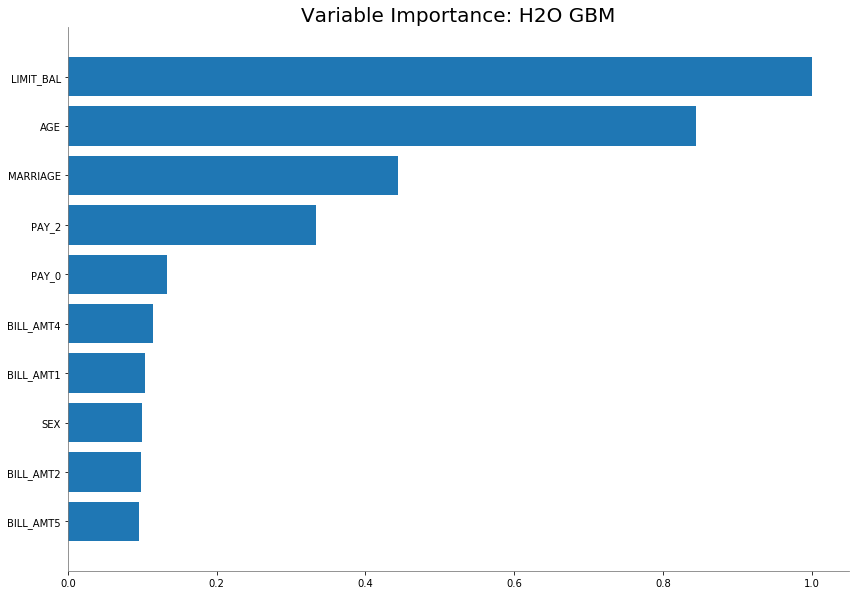

In [10]:
model.varimp_plot()

#### Display performance of model

In [11]:
perf_of_model = model.model_performance()
perf_of_model


ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.3179578124457957
RMSE: 0.5638774799952518
LogLoss: 0.8781338386600911
Mean Per-Class Error: 0.5682176533292551

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,graduate school,high school,other,university,Error,Rate
0,1611.0,58.0,0.0,926.0,0.379191,"984 / 2,595"
1,229.0,259.0,0.0,643.0,0.770999,"872 / 1,131"
2,17.0,5.0,9.0,46.0,0.883117,68 / 77
3,669.0,100.0,0.0,2441.0,0.239564,"769 / 3,210"
4,2526.0,422.0,9.0,4056.0,0.384001,"2,693 / 7,013"



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.615999
1,2,0.892771
2,3,0.992157
3,4,1.000000


#### Display confusion matrix of model

In [12]:
perf_of_model.confusion_matrix()


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,graduate school,high school,other,university,Error,Rate
0,1611.0,58.0,0.0,926.0,0.379191,"984 / 2,595"
1,229.0,259.0,0.0,643.0,0.770999,"872 / 1,131"
2,17.0,5.0,9.0,46.0,0.883117,68 / 77
3,669.0,100.0,0.0,2441.0,0.239564,"769 / 3,210"
4,2526.0,422.0,9.0,4056.0,0.384001,"2,693 / 7,013"


#### Obtain predictions on test set and cbind to test set

In [13]:
preds = model.predict(test)
preds

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,graduate school,high school,other,university
university,0.129668,0.162902,0.0143504,0.69308
university,0.369092,0.116263,0.0284222,0.486222
graduate school,0.430515,0.153518,0.0102982,0.405669
university,0.120598,0.149586,0.0163806,0.713435
university,0.261474,0.14608,0.00871461,0.583731
university,0.369631,0.180053,0.0155925,0.434724
university,0.264282,0.215662,0.013257,0.506798
university,0.294426,0.105597,0.0137803,0.586197
university,0.260939,0.117708,0.0120874,0.609265
university,0.337009,0.112512,0.0102702,0.540209


In [14]:
test_yhat = test.cbind(preds).as_data_frame()
test_yhat.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,predict,graduate school,high school,other,university
0,4,50000,female,university,married,37,1 month delay,use of revolving credit,use of revolving credit,use of revolving credit,...,1200,1100,1069,1000,0,university,0.129668,0.162902,0.014350,0.693080
1,8,100000,female,university,single,23,5 month delay,pay duly,pay duly,use of revolving credit,...,0,581,1687,1542,0,university,0.369092,0.116263,0.028422,0.486222
2,10,20000,male,high school,single,35,7 month delay,no consumption,no consumption,no consumption,...,0,13007,1122,0,0,graduate school,0.430515,0.153518,0.010298,0.405669
3,16,50000,female,high school,divorced,23,1 month delay,2 month delay,use of revolving credit,use of revolving credit,...,1100,1200,1300,1100,0,university,0.120598,0.149586,0.016381,0.713435
4,17,20000,male,graduate school,single,24,use of revolving credit,use of revolving credit,2 month delay,2 month delay,...,1500,0,1650,0,1,university,0.261474,0.146080,0.008715,0.583731


#### View classes of outcome

In [15]:
# Levels for target, EDUCATION
ed_levels = list(test_yhat[y].unique())
ed_levels

['university', 'high school', 'graduate school', 'other']

# 3. Calculate SMD Across Protected Classes

The standardized mean difference (SMD), i.e. Cohen's D, is the mean value of the prediction for the protected group minus the mean prediction for the reference group, all divided by the standard deviation of the prediction(s). SMD has some prescribed thresholds: 0.2, 0.5, and 0.8 for small, medium, and large differences, respectively. The standardized mean difference can also be used on continuous values like credit limits or loan amounts.

Since this is a multinomial classification problem, the SMD will be calculated per class outcome predictions and we will focus on the class outcome that shows the highest difference between a reference and protected group.

In [16]:
def smd_multinomial(frame, labels, j, reference, protected):
        
    protected_mean_sd_dict = collections.defaultdict(dict)
    reference_mean_sd_dict = collections.defaultdict(dict)
    smd_dict = collections.defaultdict(dict)
    
    smd_protected_frame_labels = [s + "_" + protected for s in labels]
    smd_reference_frame_labels = [s + "_" + reference for s in labels]
    
    sigma = np.std(frame[labels].values)
    #print(f"Sigma across all labels preds ({labels}): {sigma}\n")
    
    for label in labels:
        
        # Reference class frame
        reference_frame = frame[frame[j] == reference][label]
    
        # Protected class frame
        protected_frame = frame[frame[j] == protected][label]
        
        # yhat mean for class label
        mean_protected = protected_frame.mean()
        # yhat std for class label
        sigma_protected = protected_frame.std()
        #print(f"{protected.title()} mean yhat for class label, {label}: {mean_protected}")
        #print(f"{protected.title()} sigma of yhat for class label, {label}: {sigma_protected}")
        
        mean_reference = reference_frame.mean()
        sigma_reference = reference_frame.std()
        #print(f"{reference.title()} mean yhat for class label, {label}: {mean_reference}")
        #print(f"{reference.title()} sigma of yhat for class label, {label}: {sigma_reference}")
        
        protected_mean_sd_dict[label]['mean'] = mean_protected
        protected_mean_sd_dict[label]['sd'] = sigma_protected
        
        reference_mean_sd_dict[label]['mean'] = mean_reference
        reference_mean_sd_dict[label]['sd'] = sigma_reference
        
        smd = (protected_mean_sd_dict[label]['mean'] - 
               reference_mean_sd_dict[label]['mean'])/sigma
        #print(f"SMD for label, {label}: {smd}\n")
        
        smd_dict[label][reference] = 0
        smd_dict[label][protected] = smd

    j_labels=[reference, protected]
    smd_frame = pd.DataFrame(columns=j_labels,
                            index=labels)

    for row_label in labels:
        for col_label in j_labels:
            smd_frame.loc[row_label, col_label] = smd_dict[row_label][col_label]
    smd_frame = smd_frame.T
    # Sort SMD frame by SMD values for protected class
    sorted_cols = smd_frame.columns[smd_frame.loc[smd_frame.last_valid_index()].argsort()][::-1]
    return smd_frame[sorted_cols]

#### Calculate SMD across all class outcomes across gender

In [17]:
smd_mult_frame_gender = smd_multinomial(test_yhat, ed_levels, 'SEX', 'male', 'female')

In [18]:
smd_mult_frame_gender

,university,other,high school,graduate school
male,0,0,0,0
female,0.210697,0.0102466,-0.0645304,-0.156413


# 4. `One vs. all` based on SMD rankings for gender

#### Based on previous SMD rankings for gender, we can see the outcome `university` gives the biggest difference between men and women

With that said, we can do a `one vs. all` analysis for the class outcome, `university`. This is essentially conducting the typical disparate impact analysis one would do for a binary classifier. In this case, our outcome of interest is whether an observation has a `EDUCATION` level of `university` or not.

In [21]:
# Look at specific outcome based on SMD rankings
label="university"

In [22]:
# Create binary target for class outcome of interest, university
test_yhat[f"target_{label}"] = np.where(test_yhat[y] == label, 1, 0)

In [23]:
test_yhat.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,predict,graduate school,high school,other,university,target_university
0,4,50000,female,university,married,37,1 month delay,use of revolving credit,use of revolving credit,use of revolving credit,...,1100,1069,1000,0,university,0.129668,0.162902,0.014350,0.693080,1
1,8,100000,female,university,single,23,5 month delay,pay duly,pay duly,use of revolving credit,...,581,1687,1542,0,university,0.369092,0.116263,0.028422,0.486222,1
2,10,20000,male,high school,single,35,7 month delay,no consumption,no consumption,no consumption,...,13007,1122,0,0,graduate school,0.430515,0.153518,0.010298,0.405669,0
3,16,50000,female,high school,divorced,23,1 month delay,2 month delay,use of revolving credit,use of revolving credit,...,1200,1300,1100,0,university,0.120598,0.149586,0.016381,0.713435,0
4,17,20000,male,graduate school,single,24,use of revolving credit,use of revolving credit,2 month delay,2 month delay,...,0,1650,0,1,university,0.261474,0.146080,0.008715,0.583731,0


# 5. Select a Probability Cutoff by Maximizing F1 Statistic

#### Function to calculate PR-AUC Curve
Predictive models often produce probabilities, not decisions. So to make a decision with a model-generated predicted probability for any one customer, you must specify a numeric cutoff above which we say a customer will default and below which we say they will not default. Cutoffs play a crucial role in DIA as they impact the underlying measurements used to calculate diparity. In fact, tuning cutoffs carefully is a potential remdiation tactic for any discovered disparity. There are many accepted ways to select a cutoff (besides simply using 0.5) and in this notebook the cutoff will be selected by striking a balance between the model's recall (true positive rate) and it's precision using the F1 statistic. Using precision and recall to select a cutoff is sometimes seen as more robust to imbalanced data than the standard ROC approach. Maximizing F1 typically results in a good balance between sensitivity and precision.

Selecting a cutoff can be done intervactively with h2o Flow as well. Enter the url: http://localhost:54321/flow/index.html (or your H2O Connection URL displayed in cell 2) into your browser. Select Models -> List all models -> dia_gbm and you should see an interactive ROC curve where you can pick your own cutoff.

To learn more about confusion matrices see: https://en.wikipedia.org/wiki/Confusion_matrix.

In [24]:
def get_prauc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values. 
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y) # column for predicted decisions
    eps = 1e-20 # for safe numerical operations
    
    # init p-r roc frame
    prauc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prauc_frame = prauc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prauc_frame

In [25]:
def get_best_cut_per_label(label):
    prauc_frame = get_prauc(test_yhat, f"target_{label}", label)
    best_cut = prauc_frame.loc[prauc_frame['f1'].idxmax(), 'cutoff'] # Find cutoff w/ max F1
    print(f'Best cut for {label}: {best_cut}')

    # Plot P-R AUC w/ best cutoff
    title_ = 'P-R Curve: Cutoff = ' + str(best_cut) + ' for label ' + label
    ax = prauc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
    _ = ax.axvline(best_cut, color='r')

    return best_cut

#### Select best cutoff and Plot PR-AUC Curve
An area under the curve for precision and recall (PR-AUC) plot is a typical way to visualize recall and precision for a predictive model. The F1 statistic is the harmonic mean of recall and precision, and we can visualize where F1 is maximized on with the AUC-PR curve.

Best cut for university: 0.3


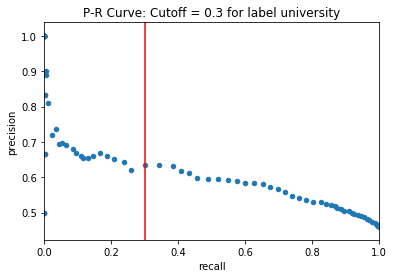

In [28]:
best_cut = get_best_cut_per_label(label)

# 6. Report Confusion Matrices
The basic DIA procedure in this notebook is based on measurements found commonly in confusion matrices, so confusion matrices are calculated as a precursor to DIA and to provide a basic summary of the GBM's behavior in general and across men and women.

In [29]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19
    
    # output results
    if by is None:
        print('Confusion matrix:')
    else:
        print('Confusion matrix by ' + by + '=' + level)
    
    return cm_frame

In [30]:
get_confusion_matrix(test_yhat, f"target_{label}", label, cutoff=best_cut)

Confusion matrix:


,actual: 1,actual: 0
predicted: 1,1256,1240
predicted: 0,122,369


#### Report confusion matrices by SEX
The only values for SEX in the dataset are female and male

In [31]:
sex_levels = list(test_yhat['SEX'].unique())
sex_levels

['female', 'male']

#### Confusion matrix for SEX = male

In [32]:
male_cm = get_confusion_matrix(test_yhat, 
                               f"target_{label}", 
                               label, 
                               by='SEX', 
                               level='male', 
                               cutoff=best_cut)
male_cm

Confusion matrix by SEX=male


,actual: 1,actual: 0
predicted: 1,476,486
predicted: 0,72,192


#### Confusion matrix for SEX = female

In [33]:
female_cm = get_confusion_matrix(test_yhat, 
                                 f"target_{label}", 
                                 label, 
                                 by='SEX', 
                                 level='female', 
                                 cutoff=best_cut)
female_cm

Confusion matrix by SEX=female


,actual: 1,actual: 0
predicted: 1,780,754
predicted: 0,50,177


# 7. Disparate Impact Analysis (DIA)
To perform the following basic DIA many different values from the confusion matrices reflecting different prediction behavior are calculated. These metrics essentially help us understand the GBM's overall performance and how it behaves when predicting:

* Education level of `university` correctly
* Education level of not `university` correctly
* Education level of `univeristy` level incorrectly (type I errors)
* Education level of non `university` level incorrectly (type II errors)

#### Dictionary of metrics used to assess disparity and parity

In [34]:
# represent metrics as dictionary for use later
metric_dict = {

#### overall performance
'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
#'Adverse Impact': '(tp + fp) / (tp + tn + fp + fn)', # how often the model predicted default for each group   
'Accuracy':       '(tp + tn) / (tp + tn + fp + fn)', # how often the model predicts default and non-default correctly for this group

#### predicting default will happen
# (correctly)
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default

#### predicting default won't happen
# (correctly)
'Specificity':              'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

#### analyzing errors - type I
# false accusations 
'False Positive Rate':  'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

#### analyzing errors - type II
# costly ommisions
'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}

#### Utility function to translate metrics into Pandas statements

In [35]:
# small utility function
# translates abbreviated metric expressions into executable Python statements

def cm_exp_parser(expression):
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', 'cm_dict[level].iat[0, 0]')\
                           .replace('fp', 'cm_dict[level].iat[0, 1]')\
                           .replace('fn', 'cm_dict[level].iat[1, 0]')\
                           .replace('tn', 'cm_dict[level].iat[1, 1]')

    return expression

#### Calculate and report metrics
This nested loop calculates all the metrics defined above for men and women.

In [36]:
# initialize dict of confusion matrices and corresponding rows of dataframe
cm_dict = {'male': male_cm, 
           'female': female_cm} 

metrics_frame = pd.DataFrame(index=sex_levels) # frame for metrics

# nested loop through:
# - sex levels
# - metrics 
for level in sex_levels:
    for metric in metric_dict.keys():
              
        # parse metric expressions into executable pandas statements
        expression = cm_exp_parser(metric_dict[metric])

        # dynamically evaluate metrics to avoid code duplication
        metrics_frame.loc[level, metric] = eval(expression)  

# display results                
metrics_frame

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
female,0.471323,0.543441,0.939759,0.508475,0.190118,0.779736,0.809882,0.491525,0.060241,0.220264
male,0.446982,0.544861,0.868613,0.494802,0.283186,0.727273,0.716814,0.505198,0.131387,0.272727


#### Plot false omissions rate by SEX

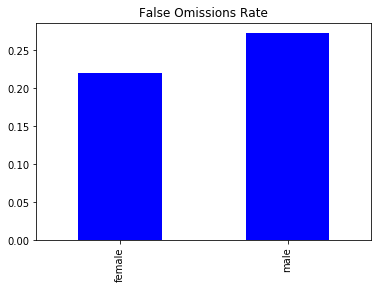

In [37]:
_ = metrics_frame['False Omissions Rate'].plot(kind='bar', color='b', title='False Omissions Rate')

#### Calculate and report disparity

To calculate disparity we compare the confusion matrix for each sex to the metrics for a user-defined reference level and to user-defined thresholds. In this case, we take the class of people who seem most priviledged as the reference level, i.e. SEX = male. (Usually the reference level would be race = white or sex = male.) According to the four-fifths rule (https://en.wikipedia.org/wiki/Disparate_impact#The_80%_rule) thresholds are set such that metrics 20% lower or higher than the reference level metric will be flagged as disparate. Technically, the four-fifths rule only applies to the adverse impact ratio, discussed further below, but it will be applied to all other displayed metrics as a rule of thumb.

In [38]:
ref_level = 'male' # user-defined reference level

parity_threshold_low = 0.8    # user-defined low threshold value
parity_threshold_hi = 1.25    # user-defined high threshold value

# init frame to store disparity measures
disp_frame = pd.DataFrame(index=sex_levels)

# compare all metrics to reference level
disp_frame = metrics_frame/metrics_frame.loc[ref_level, :]

# change column names
disp_frame.columns=[col + ' Disparity' for col in metrics_frame.columns]

# small utility function to format pandas table output
def disparate_red(val):
    
    color = 'blue' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

# display results
disp_frame.style.applymap(disparate_red)

,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
female,1.05446,0.997394,1.08191,1.02763,0.671355,1.07214,1.12984,0.972937,0.458501,0.807636
male,1,1,1,1,1,1,1,1,1,1


#### Plot false omissions rate disparity

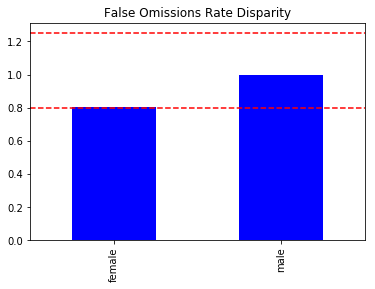

In [39]:
ax = disp_frame['False Omissions Rate Disparity'].plot(kind='bar', color='b', title='False Omissions Rate Disparity')
_ = ax.axhline(parity_threshold_low, color='r', linestyle='--')
_ = ax.axhline(parity_threshold_hi, color='r', linestyle='--')

#### Assess and report parity

A binary indication of parity for metrics is reported by simply checking whether disparity values are within the user-defined thresholds. Further parity indicators are defined as combinations of other disparity values:

Type I Parity: Both FDR Parity and FPR Parity
Type II Parity: Both FOR Parity and FNR Parity
Equalized Odds: Both FPR Parity and TPR Parity
Supervised Fairness: Both Type I and Type II Parity
Overall Fairness: Fairness across all metrics

In [40]:
# parity checks
# low_threshold (0.8) < *_metric/white_metric < (high_threshold) 1.25 => parity, else disparity 

# init frame for parity
par_frame = pd.DataFrame(index=sex_levels, 
                         columns=[col + ' Parity' for col in metrics_frame.columns])
# nested loop through: 
# - races
# - disparity metrics
for i, _ in enumerate(sex_levels):
    for j, _ in enumerate(par_frame.columns):
        par_frame.iat[i, j] = (parity_threshold_low < disp_frame.iat[i, j] < parity_threshold_hi)

# add overall parity checks
# Type I Parity: Fairness in both FDR Parity and FPR Parity
# Type II Parity: Fairness in both FOR Parity and FNR Parity
# Equalized Odds: Fairness in both FPR Parity and TPR Parity
# Supervised Fairness: Fairness in both Type I and Type II Parity
# Overall Fairness: Fairness across all parities for all metrics
par_frame['Type I Parity'] = (par_frame['False Discovery Rate Parity']) & (par_frame['False Positive Rate Parity'])
par_frame['Type II Parity'] = (par_frame['False Omissions Rate Parity']) & (par_frame['False Negative Rate Parity'])
par_frame['Equalized Odds'] = (par_frame['False Positive Rate Parity']) & (par_frame['True Positive Rate Parity'])
par_frame['Supervised Fairness'] = (par_frame['Type I Parity']) & (par_frame['Type II Parity'])
par_frame['Overall Fairness'] = par_frame.all(axis='columns')
par_frame.loc['all', :] = par_frame.all(axis='index')
    
# small utility function to format pandas table output    
def color_false_red(val):

    color = 'red' if not val else 'blue'
    return 'color: %s' % color 
    
par_frame.style.applymap(color_false_red)

,Prevalence Parity,Accuracy Parity,True Positive Rate Parity,Precision Parity,Specificity Parity,Negative Predicted Value Parity,False Positive Rate Parity,False Discovery Rate Parity,False Negative Rate Parity,False Omissions Rate Parity,Type I Parity,Type II Parity,Equalized Odds,Supervised Fairness,Overall Fairness
female,True,True,True,True,False,True,True,True,False,True,True,False,True,False,False
male,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
all,True,True,True,True,False,True,True,True,False,True,True,False,True,False,False


#### Traditional Fair Lending Measures
Along with adverse impact ratio (AIR), several measures have long-standing legal precedence in fair lending, including marginal effect and standardized mean difference. These measures are calculated and discussed here.

Simple function to calculate adverse impact ratio (AIR)
AIR is perhaps the most well-known discrimination measure. It was first delineated by the U.S. Equal Employment Opportunity Commission (EEOC) and AIR is associated with the convenient 4/5ths, or 0.8, cutoff threshold. AIR values below 0.8 can be considered evidence of illegal discrimination in many lending or employment scenarios in the U.S.

In [42]:
def air(reference, protected):

    """ Calculates the adverse impact ratio as a quotient between protected and 
        reference group acceptance rates: protected_prop/reference_prop. 
        Prints intermediate values. Tightly coupled to cm_dict. 
    
    Args:
        reference: name of reference group in cm_dict as a string.
        protected: name of protected group in cm_dict as a string.

    Returns:
        AIR as a formatted string. 
        
    """

    # reference group summary
    reference_accepted = float(cm_dict[reference].iat[1,0] + cm_dict[reference].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference].sum().sum())
    reference_prop = reference_accepted/reference_total
    print(reference.title() + ' proportion predicted to have education level of university: %.3f' % reference_prop)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected].iat[1,0] + cm_dict[protected].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected].sum().sum())
    protected_prop = protected_accepted/protected_total
    print(protected.title() + ' proportion predicted to have education level of university: %.3f' % protected_prop)

    # return adverse impact ratio
    return 'Adverse impact ratio: %.3f' % (protected_prop/reference_prop)

print(air('male', 'female'))

Male proportion predicted to have education level of university: 0.215
Female proportion predicted to have education level of university: 0.129
Adverse impact ratio: 0.599


#### Simple function to calculate marginal effect

Marginal effect describes the difference between the percent of the reference group awarded a loan and the percent of the protected group awarded a loan under a model.

In [43]:
def marginal_effect(reference, protected):

    """ Calculates the marginal effect as a percentage difference between a reference and 
        a protected group: reference_percent - protected_percent. Prints intermediate values. 
        Tightly coupled to cm_dict. 
    
    Args:
        reference: name of reference group in cm_dict as a string.
        protected: name of protected group in cm_dict as a string.

    Returns:
        Marginal effect as a formatted string. 
        
    """
    
    # reference group summary
    reference_accepted = float(cm_dict[reference].iat[1,0] + cm_dict[reference].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference].sum().sum())
    reference_percent = 100*(reference_accepted/reference_total)
    print(reference.title() + ' predicted to have education level of university: %.2f%%' % reference_percent)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected].iat[1,0] + cm_dict[protected].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected].sum().sum())
    protected_percent = 100*(protected_accepted/protected_total)
    print(protected.title() + ' predicted to have education level of university: %.2f%%' % protected_percent)
    
    # return marginal effect
    return 'Marginal effect: %.2f%%' % (reference_percent - protected_percent)

print(marginal_effect('male', 'female'))

Male predicted to have education level of university: 21.53%
Female predicted to have education level of university: 12.89%
Marginal effect: 8.64%
